# House-Cleaning: Getting rid of outliers II

In the [previous post](/2020/outlier-handling-one), we tried to clean rental offerings of outliers. We first just had a look at our data and tried to clean by simply using threshold derived from our own knowledge about flats with minor success. We got slightly better results by using the IQR rule and learned two things: First, the IQR rule works better if our data is normally distributed and, if it's not, transforming it works wonders. The second learning was that picking a threshold for each variable (either by hand or through the IQR rule) doesn't work well if our variables are strongly correlated. The IQR rule always forms a rectangular threshold-window over our data where we would be better served with an elliptical window for correlated data. And what math object has an elliptical shape? Right, a multivariate Gaussian.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_colwidth = 200

blue = "#008fd5"
red = "#fc4f30"

d = pd.read_csv("/home/corrie/Documents/Projects/immoscout/data/immo_data_feb_2020.csv")
d["totalRent"] = np.where((d["totalRent"].isnull()) | (d["totalRent"] == 0),
                          np.where( d["serviceCharge"].notnull(), d["baseRent"] + d["serviceCharge"], d["baseRent"]),
                          d["totalRent"])
def iqr(data):
    """compute the interquartile range (excluding nan)"""
    return np.nanquantile(data, 0.75) - np.nanquantile(data, 0.25)

def iqr_rule(data, factor=1.5):
    """returns an outlier filter mask using the iqr rule"""
    iqr_ = iqr(data)
    upper_fence = np.nanquantile(data, 0.75) + factor*iqr_
    lower_fence = np.nanquantile(data, 0.25) - factor*iqr_
    return (data <= upper_fence) & (data >= lower_fence)

d["livingSpace_m"] =  np.where(d["livingSpace"] <= 0, 0.5, d["livingSpace"])
d["totalRent_m"] = np.where(d["totalRent"] <= 0, 0.5, d["totalRent"])

d["logRent"] = np.log(d["totalRent_m"])
d["logSpace"] = np.log(d["livingSpace_m"])

In [2]:
plt.style.use('corrie')

## Gaussian Mixtures for Outlier Detection
So how can we use [multivariate normal distributions](https://en.wikipedia.org/wiki/Multivariate_normal_distribution) to detect outliers in our data? The idea goes as follows:
We first fit a multivariate normal distribution on our data, trying to estimate which normal distribution best describes it. Important note to make here: this method again assumes that our data is (multivariate) normally distributed.
We then compute the likelihood for each data point according to this distribution. All data points with a very low likelihood, much lower than the other data points, are then classified as outliers. <br>
The idea is probably easier to understand with some pictures:


In [3]:
# thanks joseph https://joseph-long.com/writing/colorbars/
def colorbar(mappable, label):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2)
    cbar = fig.colorbar(mappable, cax=cax, label=label)
    plt.sca(last_axes)

In [4]:
from sklego.mixture import BayesianGMMOutlierDetector

np.random.seed(20)
exam = np.random.multivariate_normal([-10, 2], [[1.8, 1.7], [1.7, 2.3]], (1000,))
outlier = np.array([[-7, -1], [-8, 7.5]])
exam = np.vstack([exam, outlier])
mod = BayesianGMMOutlierDetector(n_components=1, threshold=3.5, method="stddev").fit(exam)

df_ex= pd.DataFrame({"x1": exam[:, 0], "x2": exam[:, 1],
                   "loglik": -mod.score_samples(exam), 
                   "prediction": mod.predict(exam).astype(str)})

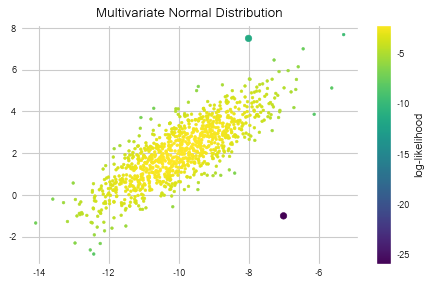

In [5]:
fig, ax = plt.subplots(dpi=80)
norm = mpl.colors.Normalize(vmin=df_ex.loglik.min(),vmax=df_ex.loglik.max())
scatter = ax.scatter(df_ex.x1, df_ex.x2, 
                          c=df_ex.loglik, cmap="viridis", norm=norm,
                          s=6, label="log-likelihood")
colorbar(scatter, label="log-likelihood")
ax.scatter(outlier[:,0], outlier[:,1], 
                c=df_ex.loglik[1000:] ,cmap="viridis", norm=norm,
                s=35)
ax.set_title("Multivariate Normal Distribution")
plt.show()

We sampled points from a multivariate normal with a high correlation between the $x$ and $y$ variable, just as in our rental data. 
The points are colored by their log-likelihood, where darker means a lower log-likelihood. I added two outliers by hand, plotted slightly larger, one in the lower right and one in the upper middle-right. As you can see, they have a much lower log-likelihood compared to the other points. We can use this and classify all points with a very low likelihood as outliers. We can for example say that all points that are more than 3.5 standard deviations away from the mean log-likelihood of all points are outliers. 

Let's see how this would compare to the IQR rule:


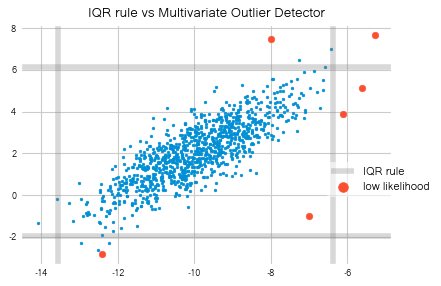

In [6]:
factor = 1.5
x1_max = np.nanquantile(exam[:,0], 0.75) + factor*iqr(exam[:,0])
x1_min = np.nanquantile(exam[:,0], 0.25) - factor*iqr(exam[:,0])

x2_max = np.nanquantile(exam[:,1], 0.75) + factor*iqr(exam[:,1])
x2_min = np.nanquantile(exam[:,1], 0.25) - factor*iqr(exam[:,1])

fig, ax = plt.subplots(dpi=80)
ax.scatter(df_ex.x1[df_ex.prediction == "-1"], df_ex.x2[df_ex.prediction == "-1"], c=red, label="low likelihood", s=35)
ax.scatter(df_ex.x1[df_ex.prediction == "1"], df_ex.x2[df_ex.prediction == "1"], c=blue, s=6)
ax.axvline(x=x1_max, c="grey", label="IQR rule", alpha=0.3, linewidth=5)
ax.axvline(x=x1_min, c="grey", alpha=0.3, linewidth=5)
ax.axhline(y=x2_max, c="grey", alpha=0.3, linewidth=5)
ax.axhline(y=x2_min, c="grey", alpha=0.3, linewidth=5)
ax.set_title("IQR rule vs Multivariate Outlier Detector")
ax.legend(markerscale=1.5, bbox_to_anchor=(0.81, .45))
plt.show()

These are the same points as above where now all points with a low log-likelihood, according to the rule specified above, are colored in red. The grey lines give the rectangular threshold as obtained from the IQR rule (using a factor of 1.5). There are quite a few points at the lower left that would be classified as outlier by the IQR rule but whose likelihood is mostly still above the log-likelihood threshold we picked. In the upper right corner, the two methods mostly agree on what classifies as an outlier but the IQR rule misses the one manually added outlier in the lower right corner. Obviously, I added this particular outlier because it highlights how a multivariate outlier detector can find outliers that arise from a correlation between two variables. Neither the $x$ nor the $y$ value of this  point is very unusual, only the combination makes it an outlier. 

Fortunately, there's a package that implements this method: [scikit-lego](https://github.com/koaning/scikit-lego). The package follows the scikit-learn API and adds some additional classifiers (such as the Gaussian mixture classifier and outlier detector) but also useful transformers and a pipeline debugger.
I'm going to use the function `GMMOutlierDetector` which implements the whole procedure described above: it fits a multivariate Gaussian on our data, computes the likelihood for each point and points with a low likelihood are flagged as outlier. Here, GMM stands for Gaussian Mixture Model.
Vincent, one of the developer of scikit-lego, explains the whole method in a few more sentences in his [talk](https://www.youtube.com/watch?v=aICqoAG5BXQ) at the PyData Berlin 2019.

Let's apply this to our data. Since the method assumes normality and we saw in the previous post that both rent and living space are closer to a normal when log-transformed, I use the variables logRent and logSpace:


In [7]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklego.mixture import GMMOutlierDetector

num_cols = ["logRent", "logSpace"]

pipe = make_pipeline(StandardScaler(),
                     GMMOutlierDetector(threshold=1.5, 
                                        method="stddev") )

pipe = pipe.fit(d[num_cols])
outlier = pipe.predict(d[num_cols])

d["outlier"] = np.where(outlier == -1, "outlier", "no_outlier")

d.outlier.value_counts()

no_outlier    267105
outlier         1745
Name: outlier, dtype: int64

The IQR rule classified around 1500 points as outliers so the Gaussian mixture outlier dectetor classified slightly more points as outlier. In percentage, this is still less than 1% though.
Let's visualize which points were classified as outliers: 


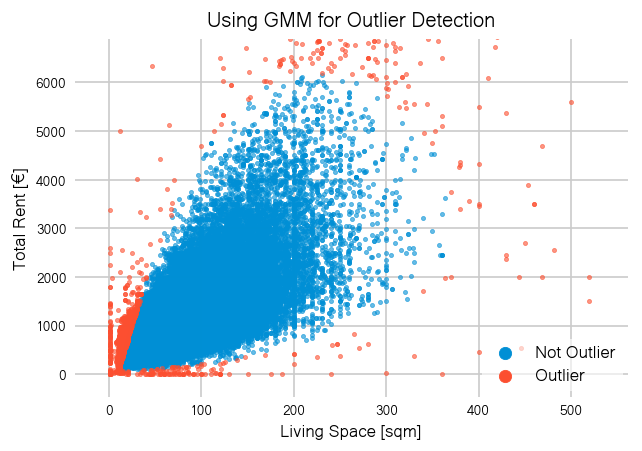

In [8]:
fig, ax = plt.subplots(dpi=120)
max_space = d[d.outlier == "no_outlier"].livingSpace.max()
max_rent = d[d.outlier == "no_outlier"].totalRent.max()
sc = ax.scatter(x=d[d.outlier == "no_outlier"].livingSpace_m, 
              y=d[d.outlier == "no_outlier"].totalRent_m, 
              label="Not Outlier", s=6, c=blue, alpha=0.6,)
sc = ax.scatter(x=d[d.outlier == "outlier"].livingSpace_m, 
              y=d[d.outlier == "outlier"].totalRent_m,
              label="Outlier", s=6, c=red, alpha=0.6,)

left, right = ax.set_xlim(-40, max_space + 200)
bottom, top = ax.set_ylim(-500, max_rent + 800)
ax.set_title("Using GMM for Outlier Detection")
leg = ax.legend(markerscale=3)
for lh in leg.legendHandles:
    lh.set_alpha(1)
ax.set_xlabel("Living Space [sqm]")
ax.set_ylabel("Total Rent [€]")
plt.show()

As the IQR rule, the method reliably detects all flats way too large or too expensive as outliers. The difference is indeed in the threshold window. Especially in the upper right we can see that the cut-off window is now elliptic instead of rectangular. 

We can see that points with a living space above 200sqm with rents below 1000€ are classified as outliers. That seems reasonable. Same for flats with a living space less than 80sqm with a rent above 2000€ or 3000€. Also seems reasonable.

However, in the lower left we see again a rather hard threshold going through our blob of data points. That doesn't look much better to what we had before. <br>
Indeed, if we look at some outliers from the lower left, we find some (depressing) realistic examples, such as this tiny flat in one of the most popular areas of Munich, newly renovated with high quality furniture for a total rent of 900€. Depressingly expensive but not unrealistic.


In [9]:
ex1 = d[["totalRent", "livingSpace", 
        "description", "regio2"]][d.outlier == "outlier"].iloc[0]
print(ex1[["totalRent", "livingSpace", "regio2"]]); ex1.description[0:545]

totalRent          900
livingSpace         18
regio2         München
Name: 46, dtype: object


'Ein kleiner möblierter Traum zwischen Englischem Garten und Münchner Freiheit.  In dieser kürzlich kernsanierten kleinen Wohnung ist buchstäblich alles neu. Vom hochwertigen Bad mit großem Handtuchwärmer, über die neue Einbauküche aus dem Küchenstudio, die wunderschönen Landhausdielen aus massivem Eichenholz, dem neuen großen Fenster mit elektrischer Rollladensteuerung in den ruhigen Innenhof, bis hin zu den Möbeln, Lampen und dem internetfähigen TV.\n\nKosten für Strom, Heizung und Kabelfernsehen sind in den Nebenkosten bereits enthalten.\n\n'

## Gaussian Mixtures enhanced

Personally, I prefer to throw away as little as possible. So I would like to keep points such as the one above in my data set.  <br>
Also, imagine we would want to analyse afterwards how rent prices developed in Munich. Throwing out these examples would make Munich look cheaper than it actually is and might heavily bias our results.  

One option is to play around with the threshold until you get a result you like. I often found this to be difficult and the results not necessarily very satisfying.  
Another problem I encountered is that some extreme outliers (e.g. a rent of 120,000€) influenced the fitting algorithm so that the resulting multivariate normal distribution was very wide. This then means that quite a few outliers are missed when increasing the threshold.

So I came up with the following method:
What if instead of fitting on the whole data set, we only fit the outlier detector on a small subset. After all, outliers are by definition rare. When we fit on a small sample there is a high probability that it doesn't contain outliers which then makes it easier to detect outliers.   However, you might easily be unlucky with the random sample you got, either finding way too many or too little outliers. Thus, instead of just sampling and fitting once, I repeatedly sample and fit. Each time fitting on a small sample, predicting on the whole data, and finally compute the relative frequency of how often a point was classified as outlier. This way, I also get a probability how likely a point is to be an outlier! Neat!

I experimented a bit which settings work best and I found that for a data set as big as this one, fitting on 1% of the data gives good results.I'm using 50 iterations but found 30 to 40 iterations to also work fine. Around 30 iterations seems to be the lowest number of iterations that still gives relatively stable results. If you use lower number of iterations, you'll end up with a very different number of outliers each time you run it.


In [10]:
def prob_outlier(outlier_detector_pipe, data, iterations=50, p=0.01):
    """repeatedly performs outlier detection on samples of the data set
    and then computes the relative frequency of how often a point was 
    classified as an outlier."""
    sample_size = int(len(data) * p)

    outlier_ar = np.empty((0, len(data)) )
    for i in range(iterations):
        outlier_detector_pipe.fit(data.sample(sample_size))

        outlier_ar = np.append(outlier_ar,  
                                [outlier_detector_pipe.predict(data)], 
                                axis=0)

    outlier = (outlier_ar == -1).mean(axis=0)
    return outlier

num_cols = ["logRent", "logSpace"]
np.random.seed(20)
d["outlier"] = prob_outlier(pipe, d[num_cols])

After thus obtaining outlier probabilities, we can have a short look at the distribution of the outlier probabilities:


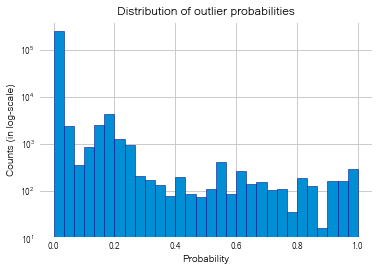

In [11]:
hist = plt.hist(d["outlier"], log=True, bins=30, ec="darkblue")
plt.title("Distribution of outlier probabilities")
plt.xlabel("Probability")
plt.ylabel("Counts (in log-scale)")
plt.show()

Most points are never classified as outliers, makes sense, most points should not be outlier. There is a small number of points that always get classified as outliers, these are most likely the very extreme outliers.  
I will use a rather conservative threshold and declare everything above 0.97 as outlier:


In [12]:
np.sum(d["outlier"] > 0.97)

291

Remember, with the IQR rule we identified around 1500 outliers and with the Gaussian mixture around 1700.   
We reduced the number of outliers by more than half! If you care about throwing away as little as possible, this is great! And even if you want to throw away more, it is very easy to change the threshold to be less conservative.

Let's have a look at the points we detect as outliers:


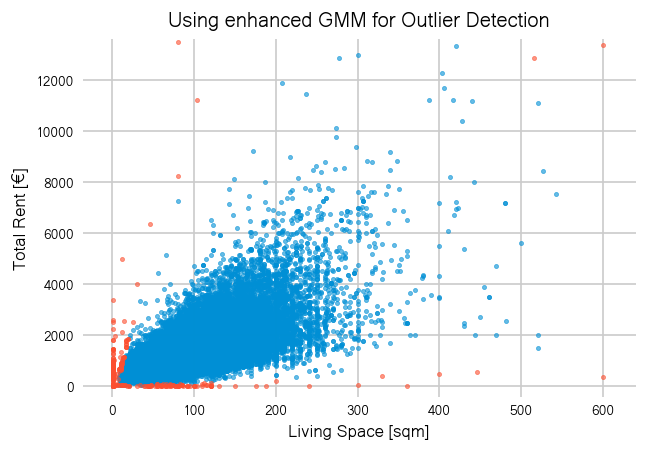

In [13]:
fig, ax  = plt.subplots(dpi=120)
d["outlier_pred"] = np.where(d["outlier"] > 0.97, 
                            "outlier", "no_outlier")
max_space = d[d.outlier_pred == "no_outlier"].livingSpace.max()
max_rent = d[d.outlier_pred == "no_outlier"].totalRent.max()

sc = ax.scatter(x=d[d.outlier_pred == "no_outlier"].livingSpace_m, 
              y=d[d.outlier_pred == "no_outlier"].totalRent_m, 
              label="Not Outlier", s=6, c=blue, alpha=0.6,)
sc = ax.scatter(x=d[d.outlier_pred == "outlier"].livingSpace_m, 
              y=d[d.outlier_pred == "outlier"].totalRent_m, 
              label="Outlier", s=6, c=red, alpha=0.6,)

ax.set_title("Using enhanced GMM for Outlier Detection")
ax.set_xlabel("Living Space [sqm]")
ax.set_ylabel("Total Rent [€]")
left, right = ax.set_xlim(-40, max_space + 100)
bottom, top = ax.set_ylim(-500, max_rent + 400)
plt.show()

We still remove all the extreme outliers (good!) and all flats where either the living space or total rent is very close to zero. Compared to above, the method removes much less of the very small but expensive flats.
We can have a look at the descriptions of some of the outliers:


In [14]:
d[["totalRent", "livingSpace","regio2", "description", ]][d.outlier_pred == "outlier"].head(10)

,totalRent,livingSpace,regio2,description
467,900.00,11.00,München,"Hello, we are homefully and this is our flat Marcello.\n\nLive in the heart of Munich with a nice view over the beautiful skyline of the city! Just across the street is the famous Viktualienmarkt ..."
2828,4020.00,30.00,Märkisch_Oderland_Kreis,"Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ..."
3377,1655.00,17.00,Frankfurt_am_Main,"Diese Boardinghouse Anlage – 2 Jahre jung - befindet sich in einer zentralen Lage in Frankfurt am Main, Nähe Hauptbahnhof und Messe. Perfekt um schnell in alle Stadtteile oder in die City zu gelan..."
3546,20466.12,362.88,München,"Dieses einzigartige, elegante und lichtdurchflutete Penthouse befindet sich am Anfang der exklusiven und ruhigen Königinstrasse, welche hier nur auf der westlichen Seite bebaut ist. Gegenüber auf ..."
4896,1.00,60.00,Teltow_Fläming_Kreis,Das Objekt befindet sich im 3. Obergeschoss in einer waldreichen Lage. In der Wohnung sind noch kleinere Renovierungsarbeiten durchzuführen.
4901,1450.00,0.00,Aschaffenburg,Ihr möbliertes Apartment! \nSie benötigen aufgrund beruflichen oder privatem Anlass ein Apartment für einen bestimmten Zeitraum?\n\nDann sind Sie hier genau richtig! Wir bieten Ihnen \n-flexible B...
6811,780.00,0.00,Rems_Murr_Kreis,"Das Objekt verfügt über vier hübsche Zimmer mit Eßdiele und 2 Balkone. Am Südhang mit Aussicht gelegen. \nKaltmiete 780,- Euro + Nebenkosten + Garage + 3 Monatsmieten Kaution.\nEnergieausweis in A..."
8871,5000.00,12.00,Märkisch_Oderland_Kreis,NaN
11994,0.00,1717.74,Chemnitz,"Diese großzügig geschnittene Villa überzeugt durch ihren glanzvollen Charme. Ursprünglich war das Haus eine private Entbindungsklinik unter der Leitung von Dr. Uhle, ein bekannter Chirurg und Frau..."
12489,494.00,0.00,Meißen_Kreis,Die behindertengerechte Wohnung finden Sie im 2. Obergeschoss eines sanierten Mehrfamilienhauses mit Aufzug. Zur Wohnung gehört ein Kellerabteil. Je nach Verfügbarkeit kann ein PKW Stellplatz für ...


We see a few objects for which it seems someone just forgot to enter the correct living space. Quite a few others are boarding houses and short term rentals. The lorem ipsum flat for more than 4000€ has also correctly been identified as outlier. There's one penthouse in Munich for 20,000€ where I'm not sure if it might be the real total rent, I'm not really familiar with rental prices of penthouses.

## Going beyond two dimensions
A nice thing about the Gaussian mixture outlier detection method is, that it can easily be extended to more than two columns. In this data set for example there are two more variables that also commonly have input errors: the number of rooms and the construction year.
For the construction year, we have different options to use it in our model: either use as is or use the log transformed age of a building. Unfortunately, both ways have disadvantages: If we use the construction year as is, we will detect many very old houses as outliers and even though buildings from the middle age are rare, Germany has quite a few cities with many very old buildings. If instead we use the log transformed age, we miss many outliers: there are for example suspiciously many buildings constructed in 1111. For these kind of outliers, we would need a different approach. 
For this analysis, I used the log transformed age and also log transformed the number of rooms. The later helps in identifying cases where the number of rooms is too high for the amount of living space. As a high number of observations also do not have a construction year, I will do this part only on a subset.


In [15]:
d["age"] = 2021.5 - d["yearConstructed"]
d["logAge"] = np.log(d["age"])
d["logRooms"] = np.log(d["noRooms"])

mask = d["logAge"].notnull()
ds = d[mask].copy()

ds["outlier"] = np.nan
ds["outlier"] = prob_outlier(pipe, 
            ds[["logRent", "logSpace", "logRooms", "logAge"]])

Let's have a look at a few examples identified as outlier:

In [16]:
ds[ds.outlier >= 0.8][["totalRent", "yearConstructed", "livingSpace", "noRooms", "description"]]\
    .sort_values(by="noRooms", ascending=False)\
    .head(10)

,totalRent,yearConstructed,livingSpace,noRooms,description
103393,422.0,1999.0,61.17,999.99,NaN
160185,445.0,1957.0,53.00,230.00,Wir präsentieren Ihnen hier eine sehr schöne und gepflegte 2- Zimmer Wohnung in Radevormwald. Die Wohnung bietet einem 1-2 Personenhaushalt ausreichend viel Platz und vermittelt durch die gute Gru...
134795,565.0,2014.0,20.00,221.00,"Das Gebäude befindet sich in dem jüngsten Stadtteil Heidelbergs, der Bahnstadt. \nDen Mietern steht kostenlos ein Fitnessraum zur Verfügung. \nEbenso Waschmaschinen und Trockner gegen Bezahlung."
225073,350.0,1994.0,30.00,160.00,"Die Wohnparkanlage ""Auf der Goldenen Höhe"" liegt im südlichen Teil der Stadt Waldheim, am Ortsrand des Stadtteiles Schönberg. \nHierbei handelt es sich um ein allgemeines Wohngebiet, das heißt den..."
25529,395.0,1993.0,14.00,140.00,"In der ruhigen Dreyerstraße Nr. 8 + 9 gelegen, erstrecken sich die beiden Apartmenthäuser entlang des Leinebogens. Wohnen könnt ihr hier auf sechs Ebenen mit Blick auf ganz Hannover.\n\n\nDer Gebä..."
172439,900.0,2001.0,100.00,100.00,Die 3 Zimmerwohnung befindet sich in einem Wohn- und Geschäftshaus in der Bahnhofstr. 16 in 21629 Neu Wulmstorf. In der unmittelbaren Umgebung befinden sich sämtliche Geschäfte des täglichen Bedar...
116132,1970.8,2018.0,3.00,99.50,Die hochwertige Etagenwohnung in der Delbrückstraße 41 liegt im Vorderhaus eines Mehrfamilienhauses in Berlin-Neukölln. Die 3-Zimmer-Wohnung im 3. OG ist ca. 99 m² groß und liegt in sonniger Süd-A...
231370,2230.0,1960.0,186.61,79.00,Sie wollten schon immer in der City von Hannover wohnen? Dann sind Sie hier an der richtigen Adresse. Sie können in dieser großzügig geschnittenen 6-Zimmer-Wohnung sicher viele Ihrer Wohnträume ve...
89830,911.0,2019.0,2257.88,75.50,"*****Bitte beachten Sie, der angegebene Preis im Portal betrifft die günstigste Wohnung. Beachten Sie bitte die Preisaufstellung in der Beschreibung!******\n\n\nIn der Stadtmitte in der Nähe des B..."
162001,1500.0,1960.0,150.00,45.00,Doppelhaushälfte 60er Jahre mit nicht einsehbarer großer Terrasse und Garten auf wunderschönem Grundstück in bevorzugter Lage von Wuppertal-Katernberg.


They are quite a few cases where whole appartment blocks are sold for which the living space and total rent often denotes the living space and total rent of a single unit but the number of rooms denote the total number of appartments that are up for rent. 

Let's have a short look at the plot for living space versus number of rooms:

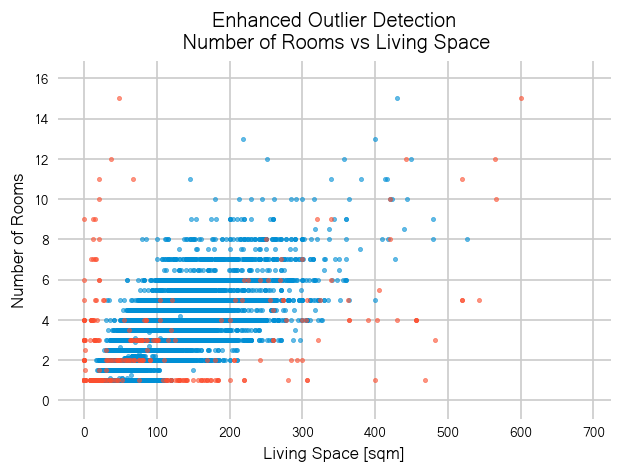

In [17]:
fig, ax  = plt.subplots(dpi=120)
ds["outlier_pred"] = np.where(ds["outlier"] >= 0.8, "outlier", "no_outlier")
max_space = ds[(ds.outlier_pred == "no_outlier") ].livingSpace.max()
max_rooms = ds[(ds.outlier_pred == "no_outlier") ].noRooms.max()
ax.scatter(x=ds[ds.outlier_pred == "no_outlier"].livingSpace_m, c=blue, alpha=0.6,
              y=ds[ds.outlier_pred == "no_outlier"].noRooms, label="Not Outlier", s=6)
ax.scatter(x=ds[ds.outlier_pred == "outlier"].livingSpace_m, c=red, alpha=0.6,
              y=ds[ds.outlier_pred == "outlier"].noRooms, label="Outlier", s=6)

left, right = ax.set_xlim(-40, max_space + 200)
bottom, top = ax.set_ylim(-1, max_rooms + 2)
ax.set_xlabel("Living Space [sqm]")
ax.set_ylabel("Number of Rooms")
ax.set_title("Enhanced Outlier Detection\n Number of Rooms vs Living Space")
plt.show()

The method identifies everything with more than 15 rooms as outlier and cases with a a very small living space (around less than 30sqm) with too many rooms as outliers. Great! It also thinks that flats with a very large living area above e.g. 100sqm but with only one room are likely outliers. That sounds very reasonable. 

## Summary

In general, outlier detection is a hard problem: what constitutes an outlier is often not obvious and can depend on the context. I found it useful to check a few cases by hand and see if I can identify an underlying cause.  

Sometimes, we can take advantage of domain knowledge and then identify these problematic cases in a more efficient way. For example, this data contained many shared flats with misleading values for the living space. A simple regex might be very efficient to identify these cases. 

Results improve significantly if variables are transformed appropriately. Both the Gaussian mixture method and the IQR rule assume that the data follow a normal distribution and results are suboptimal if our data does not. <br>
Of course, other outlier detection methods don't assume normality but they always assume something and it is important to be aware which assumptions are being made and to make sure they are met. 

The assumptions also determine what kind of outliers can be detected. The methods used in this analysis assume normality and then define outliers as points that don't follow normality, i.e. that are far from the center. Thus, they can't detect outliers such as flats built in 1111. There definitely are quite a few real offers in this data built aroud the 10th century but most flats built in 1111 were probably just people being lazy when inputting the construction year.

[Link](https://github.com/corriebar/blogdown_source/content/post/2020/2020-02-24-outlier-handling-2.ipynb) to the jupyter notebook used to make this blogpost.